In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
import itertools
import librosa
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, 
                             balanced_accuracy_score, precision_score, recall_score, 
                             confusion_matrix, ConfusionMatrixDisplay, roc_auc_score,
                             average_precision_score)

from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

DATASET_PATH = "dataset/"
AUDIO_PATH = DATASET_PATH + "audio"
LABELS_PATH = DATASET_PATH + "labels"
FEATURES_PATH = DATASET_PATH + "audio_features"

## 1. Labeling Function

For your analysis, you may focus on a subset of the 58 classes provided. <br>

(a) Assess how accurately the applied labeling functions capture the intended classes. Do the mapped classes correspond well to the free-text annotations? Are the labeled events clearly audible within the indicated time regions?<br>
(b) Which audio features appear most useful for distinguishing between the classes of interest? <br>
(Hint: You can, for example, compare feature distributions across classes or quantitatively evaluate how features relate to the target labels.) <br>
(c) How well do the chosen audio features group according to the discretized class labels? Do samples of the same class form tight clusters?

In [3]:
# load the metadata
metadata = pd.read_csv(DATASET_PATH + "metadata.csv")

# load the annotations
annotations_df = pd.read_csv(DATASET_PATH + "annotations.csv")
annotations_embeddings = np.load(DATASET_PATH + "annotations_text_embeddings.npz")["embeddings"]
  
# load audio features
feature_filename = metadata.loc[0, "filename"].replace("mp3", "npz")
features = np.load(os.path.join(FEATURES_PATH, feature_filename))
print(list(features.keys()))
print("Shape of ZCR feature (time, n_features)", features["zerocrossingrate"].shape)
print("Shape of MFCC features (time, n_features)", features["mfcc"].shape)

['embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2', 'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth', 'contrast', 'zerocrossingrate']

['embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2', 'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth', 'contrast', 'zerocrossingrate']
Shape of ZCR feature (time, n_features) (184, 1)
Shape of MFCC features (time, n_features) (184, 32)


['embeddings',
 'melspectrogram',
 'mfcc',
 'mfcc_delta',
 'mfcc_delta2',
 'flatness',
 'centroid',
 'flux',
 'energy',
 'power',
 'bandwidth',
 'contrast',
 'zerocrossingrate']

In [4]:
def viz_annot(audio_filename, label_names, annotations_df):
    audio_path = os.path.join(AUDIO_PATH, audio_filename)
    waveform, sr = librosa.load(audio_path, sr=16000)
    time = np.linspace(0, len(waveform) / sr, num=len(waveform))

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(time, waveform)
    plt.title(f"Waveform: {audio_filename}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.subplot(2, 1, 2)
    for label_name in label_names:
        label_filename = audio_filename.replace(".mp3", "_labels.npz")
        label_path = os.path.join(LABELS_PATH, label_filename)
        labels = np.load(label_path)
        
        # check if label exists
        if label_name in labels:
            label_activity = labels[label_name].mean(axis=-1)
        else:
            label_activity = np.zeros_like(labels[list(labels.keys())[0]].mean(axis=-1))

        plt.plot(np.linspace(0, len(label_activity) * (len(waveform) / sr) / len(label_activity), len(label_activity)), label_activity, label=label_name)
        plt.yticks([0, 1], ['Inactive', 'Active'])

    plt.ylabel("Label Activity")
    plt.xlabel("Time (s)")

    relevant_annotations = annotations_df[annotations_df['filename'] == audio_filename]
    if 'onset' in relevant_annotations.columns and 'offset' in relevant_annotations.columns and 'annotation' in relevant_annotations.columns:
        for index, row in relevant_annotations.iterrows():
            start = row['onset']
            end = row['offset']
            annotation_text = row['annotation']
            plt.axvspan(start, end, color='red', alpha=0.2, label='Annotation Region' if index == 0 else "")
            plt.text((start + end) / 2, 0.8, annotation_text, ha='center', va='center', color='red')

    plt.tight_layout()
    plt.legend()
    plt.show()


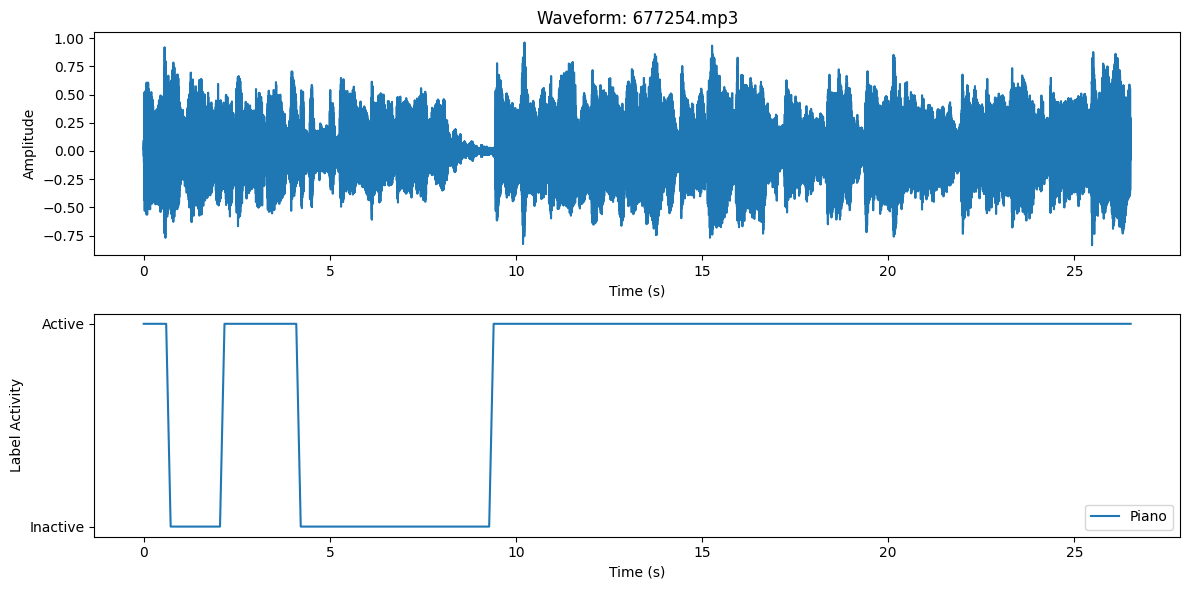

In [5]:
filename = metadata.loc[24, "filename"]
viz_annot(filename, ["Piano"], annotations_df)
ipd.Audio(os.path.join(AUDIO_PATH, filename))

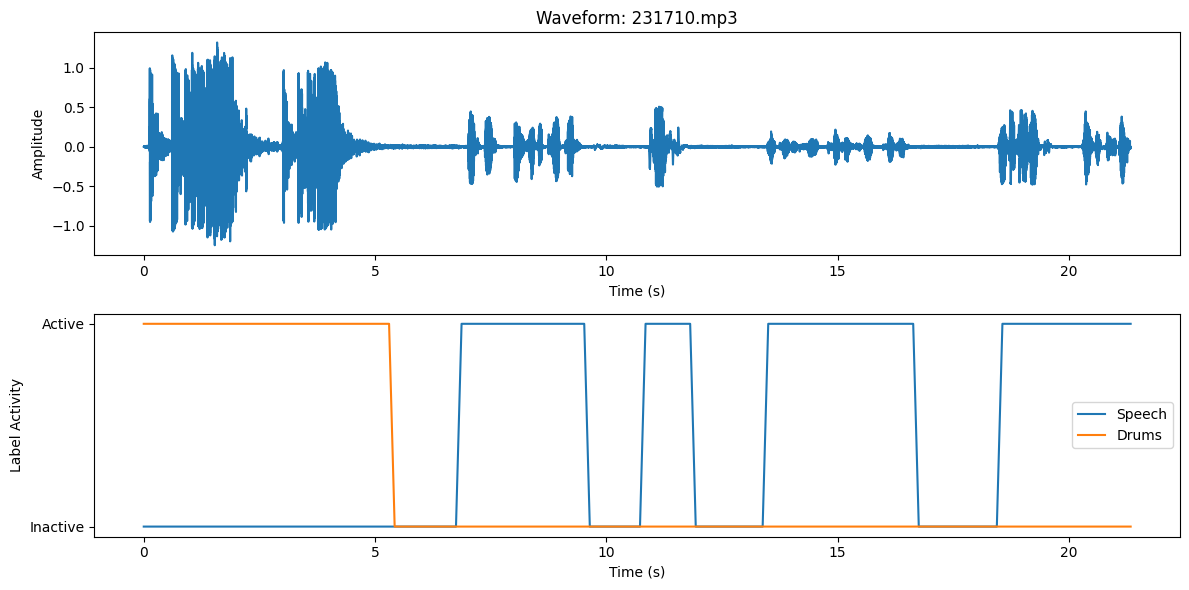

In [6]:
filename = metadata.loc[17, "filename"]
viz_annot(filename, ["Speech", "Drums"], annotations_df)
ipd.Audio(os.path.join(AUDIO_PATH, filename))

## 2. Data Split

(a) Describe how you split the data for model selection and performance evaluation. <br>
Remember: you will need to train your model, tune hyperparameters, and estimate final performance. <br>
(b) Are there any potential factors that could cause information leakage across the data splits if they are not carefully designed? If yes, how did you address these risks? <br>
(c) Describe how you obtained unbiased final performance estimates for your models.

In [7]:
categories = [
        'Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

train_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[:int(len(metadata) * 0.8)]
validation_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[int(len(metadata) * 0.8):int(len(metadata) * 0.9)]
test_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[int(len(metadata) * 0.9):]

print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(validation_files)}")
print(f"Test files: {len(test_files)}")


Train files: 6584
Validation files: 823
Test files: 823


In [8]:
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: # The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

def read_files(file_names, num_to_read=1000):
    X_train = []
    Y_train = {}
    for c in categories:
        Y_train[c] = []
    for f in file_names[:num_to_read]: # we are not loading the entire dataset due to processing time
        if not os.path.exists(os.path.join(FEATURES_PATH , f.split('.')[0] + '.npz')):
            continue
        features = np.load(os.path.join(FEATURES_PATH , f.split('.')[0] + '.npz'))["embeddings"]
        X_train.append(features)
        y = np.load(os.path.join(LABELS_PATH , f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y)))

    X_train = np.concatenate(X_train)
    return X_train, Y_train

## 3. Audio Features

(a) Which subset of audio features did you select for your final classifier? Describe the selection process and the criteria you used to make your choice. <br>
(b) Did you apply any preprocessing to the audio features? If so, explain which techniques you used and why they were necessary.

In [99]:
train_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[:int(len(metadata) * 0.8)]
X_train, Y_train = read_files(train_files, 500)

validation_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[int(len(metadata) * 0.8):int(len(metadata) * 0.9)]
X_val, Y_val = read_files(validation_files, -1)

test_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[int(len(metadata) * 0.9):]
X_test, Y_test = read_files(test_files, -1)

In [100]:
scaler = StandardScaler()
pca = PCA(n_components=100, random_state=42)

X_train_pca = pca.fit_transform(scaler.fit_transform(X_train))
X_val_pca    = pca.transform(scaler.transform(X_val))

## 4. Evaluation

(a) Which evaluation criterion did you choose to compare hyperparameter settings and algorithms, and why? <br>
(b) What is the baseline performance? What could be the best possible performance?

In [79]:
def print_metrics(y_true, pred):
    accuracy      = accuracy_score(y_true, pred)
    precision     = precision_score(y_true, pred, zero_division=0)
    recall        = recall_score(y_true, pred)
    f1            = f1_score(y_true, pred)
    roc_auc       = roc_auc_score(y_true, pred)
    pr_auc        = average_precision_score(y_true, pred)
    weighted_acc  = balanced_accuracy_score(y_true, pred)

    print(f"Accuracy:         {accuracy:.3f}")
    print(f"Weighted Accuracy:{weighted_acc:.3f}")
    print(f"Precision:        {precision:.3f}")
    print(f"Recall:           {recall:.3f}")
    print(f"F1 Score:         {f1:.3f}")
    print(f"ROC AUC:          {roc_auc:.3f}")
    print(f"PR AUC:           {pr_auc:.3f}\n")

### Baseline Classifier

In [80]:
class Baseline_classifier():

    def __init__(self):
        self.majority_class = None

    def fit(self, x_train, y_train):
        self.majority_class =  1 if sum(y_train) > len(y_train) / 2 else 0

    def predict(self, x):
        predictions = np.zeros(x.shape[0]) + self.majority_class
        return predictions

In [81]:
files = ["231710.mp3"]
X_train_base, Y_train_base = read_files(files, len(files))

labels_to_predict = ['Drums', 'Speech']
y_pred = {}
for label in labels_to_predict:
    
    y_train = np.array(Y_train_base[label])
    
    baseline = Baseline_classifier()
    baseline.fit(X_train_base, np.array(y_train))

    y_pred[label] = baseline.predict(X_train_base)
    train_fraction_correct = np.mean(y_pred[label] == y_train)
    print_metrics(Y_train_base[label], y_pred[label])
    
display(ipd.Audio(os.path.join(AUDIO_PATH, files[0])))

Accuracy:         0.747
Weighted Accuracy:0.500
Precision:        0.000
Recall:           0.000
F1 Score:         0.000
ROC AUC:          0.500
PR AUC:           0.253

Accuracy:         0.534
Weighted Accuracy:0.500
Precision:        0.000
Recall:           0.000
F1 Score:         0.000
ROC AUC:          0.500
PR AUC:           0.466



## 5. Experiments

(a) For at least three different classifiers, systematically vary the most important hyperparameters and answer the following questions for each of them: <br>
i. How does classification performance change with varying hyperparameter values? Visualize the change in performance. <br>
ii. (To what extent) Does overfitting or underfitting occur, and what does it depend on? <br>
(b) After selecting appropriate hyperparameters, compare the final performance estimate of the three classifiers.

### K-nearest Neighbors Classifier

In [101]:
def train_and_evaluate(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    prediction = model.predict(x_val)
    
    score = 0
    if y_val.ndim == 1:
        score = balanced_accuracy_score(y_val, prediction, adjusted=True)
    else:
        scores = [balanced_accuracy_score(y_val[:, i], prediction[:, i]) for i in range(y_val.shape[1])]
        score = np.mean(scores)

    return score

n_neighbors=1 --> Accuracy: 0.3185
n_neighbors=26 --> Accuracy: 0.3292
n_neighbors=51 --> Accuracy: 0.3335
n_neighbors=76 --> Accuracy: 0.3280
n_neighbors=101 --> Accuracy: 0.3372
n_neighbors=126 --> Accuracy: 0.3333
n_neighbors=151 --> Accuracy: 0.3417
n_neighbors=176 --> Accuracy: 0.3427
n_neighbors=201 --> Accuracy: 0.3442
n_neighbors=226 --> Accuracy: 0.3451
n_neighbors=251 --> Accuracy: 0.3465
n_neighbors=276 --> Accuracy: 0.3473
n_neighbors=301 --> Accuracy: 0.3483
n_neighbors=326 --> Accuracy: 0.3477
n_neighbors=351 --> Accuracy: 0.3480
n_neighbors=376 --> Accuracy: 0.3460
n_neighbors=401 --> Accuracy: 0.3461
n_neighbors=426 --> Accuracy: 0.3455
n_neighbors=451 --> Accuracy: 0.3446
n_neighbors=476 --> Accuracy: 0.3441


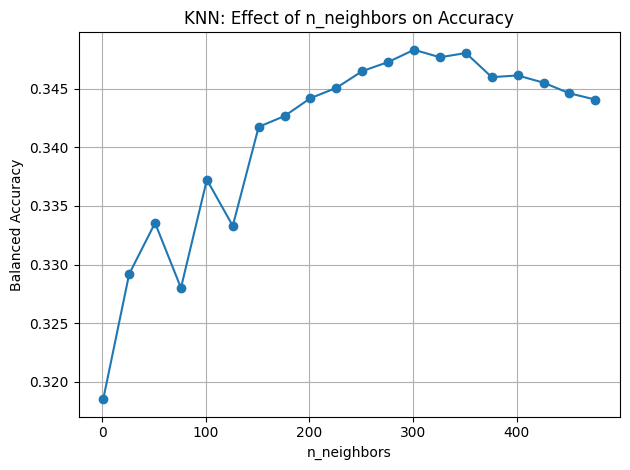

In [102]:
labels_to_predict = 'Thunder'
knn_x_train, knn_y_train = X_train_pca, np.array(Y_train[labels_to_predict])
knn_x_val, knn_y_val = X_val_pca, np.array(Y_val[labels_to_predict])

best_knn_model = None
best_knn_score = 0

knn_scores = []
n_neighbors = range(1, 500, 25)
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    score = train_and_evaluate(knn, knn_x_train, knn_y_train, knn_x_val, knn_y_val)
    knn_scores.append(score)
    print(f"n_neighbors={n} --> Accuracy: {score:.4f}")
    
    if score > best_knn_score:
        best_knn_score = score
        best_knn_model = knn

plt.figure()
plt.plot(n_neighbors, knn_scores, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Balanced Accuracy')
plt.title('KNN: Effect of n_neighbors on Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()  

### Decision Tree Classifier

In [ ]:
labels_to_predict = 'Thunder'
dtc_x_train, dtc_y_train = X_train_pca, np.array(Y_train[labels_to_predict])
dtc_x_val, dtc_y_val = X_val_pca, np.array(Y_val[labels_to_predict])

param_grid = {
    'max_depth': [None],
    'min_samples_split': [2, 5, 10, 25],
    'min_samples_leaf': [1, 2, 5, 10, 25],
    'criterion': ['gini', 'entropy']
}

for max_depth, min_samples_split, min_samples_leaf, criterion in itertools.product(*(param_grid[key] for key in list(param_grid.keys()))):
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion, min_samples_leaf=min_samples_leaf, random_state=42)
    score = train_and_evaluate(model, dtc_x_train, dtc_y_train, dtc_x_val, dtc_y_val)
    print(f"Params: max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, criterion={criterion} --> Accuracy: {score:.4f}")
    
# Params: max_depth=50, min_samples_split=20, criterion=entropy, min_samples_leaf=5 --> Accuracy: 0.2800

Params: max_depth=50, min_samples_split=2, min_samples_leaf=1, criterion=gini --> Accuracy: 0.2594
Params: max_depth=50, min_samples_split=2, min_samples_leaf=1, criterion=entropy --> Accuracy: 0.2709
Params: max_depth=50, min_samples_split=2, min_samples_leaf=2, criterion=gini --> Accuracy: 0.2463
Params: max_depth=50, min_samples_split=2, min_samples_leaf=2, criterion=entropy --> Accuracy: 0.2709
Params: max_depth=50, min_samples_split=2, min_samples_leaf=5, criterion=gini --> Accuracy: 0.2328
Params: max_depth=50, min_samples_split=2, min_samples_leaf=5, criterion=entropy --> Accuracy: 0.2655
Params: max_depth=50, min_samples_split=2, min_samples_leaf=10, criterion=gini --> Accuracy: 0.2484
Params: max_depth=50, min_samples_split=2, min_samples_leaf=10, criterion=entropy --> Accuracy: 0.2558
Params: max_depth=50, min_samples_split=2, min_samples_leaf=25, criterion=gini --> Accuracy: 0.2412
Params: max_depth=50, min_samples_split=2, min_samples_leaf=25, criterion=entropy --> Accuracy

### Random Forest Classifier with Multi-Label Classification

In [ ]:
selected_classes = categories
mlc_x_train, mlc_y_train = X_train_pca, np.array([Y_train[cls] for cls in selected_classes]).T
mlc_x_val, mlc_y_val = X_val_pca, np.array([Y_val[cls] for cls in selected_classes]).T

param_grid = {
    'n_estimators':       [len(selected_classes)],
    'max_depth':          [30],
    'min_samples_split':  [10],
    'criterion':          ['entropy']
}

for n_estimators, max_depth, min_samples_split, criterion in itertools.product(*(param_grid[key] for key in list(param_grid.keys()))):
    rfc = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion=criterion,
        random_state=42,
        n_jobs=-1
    )
    
    model = MultiOutputClassifier(rfc)
    score = train_and_evaluate(model, mlc_x_train, mlc_y_train, mlc_x_val, mlc_y_val)
    print(f"Params: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, criterion={criterion} --> Macro Balanced Accuracy: {score:.4f}")
    
    if score > best_score:
        best_score  = score
        best_model  = model

Params: n_estimators=58, max_depth=30, min_samples_split=10, criterion=entropy --> Macro Balanced Accuracy: 0.6472


## 6. Analyzing Predictions

Find two interesting audio files that have not been used for training and qualitatively evaluate your classifier’s predictions. <br>

(a) Use the spectrogram and the sequence of predictions to visualize the classifier output. <br>
(b) Listen to the audios and inspect the corresponding predictions of the classifier. How well does the classifier recognize the classes? <br>
(c) What are particular problematic conditions that cause the classifier to mispredict classes? Can you think of simple postprocessing steps that might help improve the predictions?

In [22]:
def evaluate_audio(files, pred_labels, model, features_dir, labels_dir):
    print(files)
    for file in files:
        audio_path = os.path.join(AUDIO_PATH, file)
        waveform, sr = librosa.load(audio_path)
        time = np.linspace(0, len(waveform) / sr, num=len(waveform))
        
        feature_file = os.path.join(features_dir, file.replace(".mp3", ".npz"))
        label_file = os.path.join(labels_dir, file.replace(".mp3", "_labels.npz"))
        features = np.load(feature_file)["embeddings"]
        labels = np.load(label_file)
        
        predictions = model.predict(pca.transform(scaler.transform(features)))
        
        plt_labels = {}        
        for idx, pred_label in enumerate(pred_labels):
            if pred_label in labels:
                label_activity = labels[pred_label].any(axis=-1).astype(int)
                prediction = predictions[:, idx]
                if np.sum(label_activity) != 0 or np.sum(prediction) != 0:
                    plt_labels[pred_label] = (label_activity, prediction)
        
        plt.figure(figsize=(8, 2 * (len(plt_labels) + 1)))
        plt.subplot(len(plt_labels) + 1, 1, 1)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
        # plt.colorbar(format='%+2.0f dB')
        plt.title(f"Spectrogram: {file}")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        
        for idx, (label, (label_activity, predictions)) in enumerate(plt_labels.items(), start=2):
            plt.subplot(len(plt_labels) + 1, 1, idx)
            plt.plot(np.linspace(0, len(label_activity) * (len(waveform) / sr) / len(label_activity), len(label_activity)), label_activity, label="Ground Truth")
            plt.plot(np.linspace(0, len(predictions) * (len(waveform) / sr) / len(predictions), len(predictions)), predictions, label="Predictions", alpha=0.7)
            plt.yticks([0, 1], ['Inactive', 'Active'])
            plt.xlabel("Time (s)")
            plt.ylabel(label)
            plt.legend()
        plt.tight_layout()
        plt.show()
        
        display(ipd.Audio(audio_path))

In [29]:
import pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

['406790.mp3']


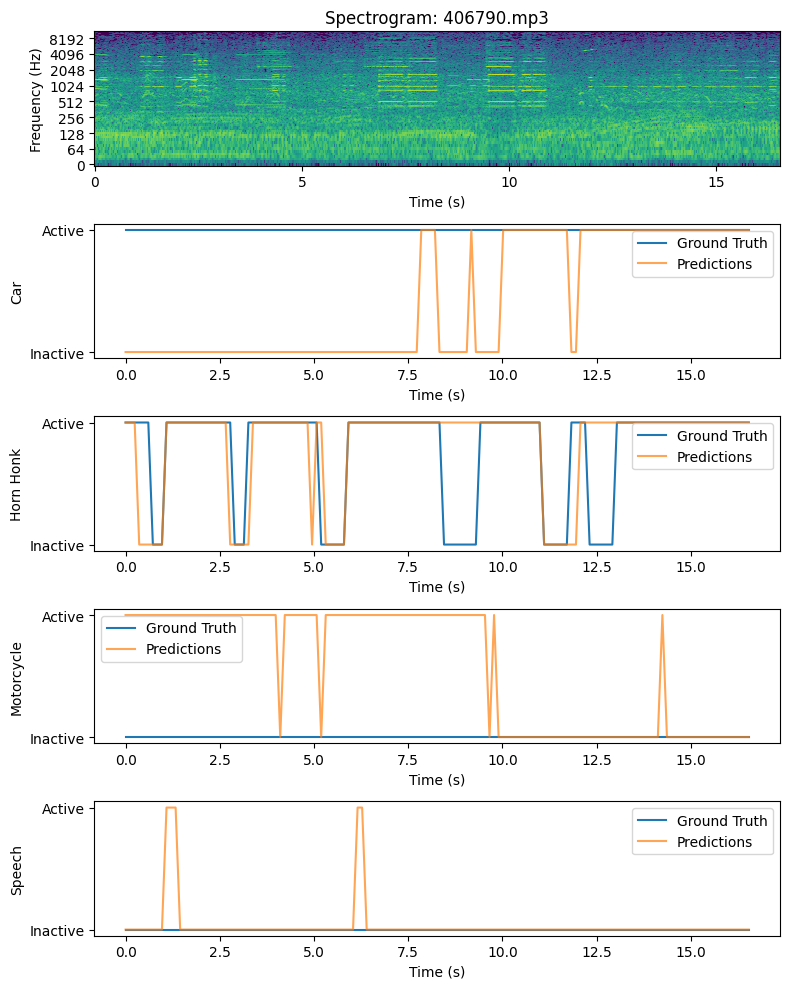

In [172]:
files = list(np.random.choice(test_files, 1))
audio = evaluate_audio(files, categories, best_model, FEATURES_PATH, LABELS_PATH)
# display(audio)

# audio = evaluate_audio(['393694.mp3'], ['Dog Bark'], best_model, FEATURES_PATH, LABELS_PATH)
# display(audio)

In [ ]:
with open('best_rfc_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

['23893.mp3']


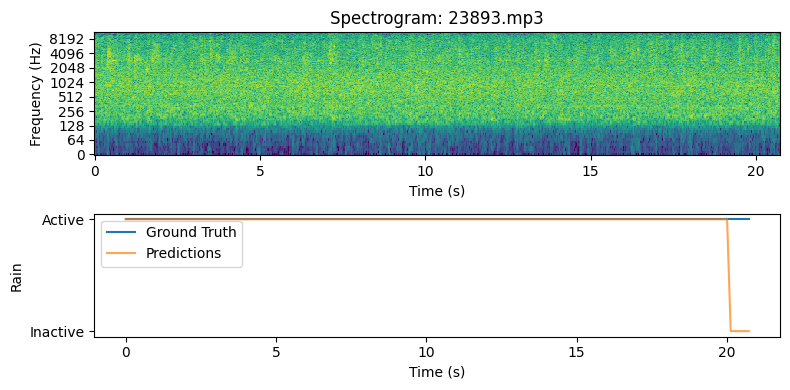

In [73]:
files = list(np.random.choice(test_files, 1))
audio = evaluate_audio(files, categories, loaded_model, FEATURES_PATH, LABELS_PATH)